### **Project Goal:**  

The goal of this project is to build an end-to-end deep learning model using the CIFAR dataset and show how different regularization techniques can improve the model’s performance and prevent overfitting.

**Objectives:**  
- Load and prepare the CIFAR dataset for training and testing.  
- Build a baseline convolutional neural network (CNN) without regularization.  
- Train and evaluate the baseline model to observe overfitting.  
- Apply different regularization techniques like dropout, weight decay (L2 regularization), and data augmentation.  
- Compare and analyze how each regularization method affects the model’s training, validation, and test performance.  
- Summarize the findings with clear visualizations and conclusions.


**Step 1: Load and Prepare the Data**  
We start by loading the CIFAR dataset, which contains `60,000` small color images divided into 10 classes. The dataset is split into a training set and a test set. After loading, we normalize the pixel values (scale them between `0` and `1`) to make training faster and more stable. We can also set up a validation set by splitting part of the training data.


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")


Training set shape: (45000, 32, 32, 3)
Validation set shape: (5000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


### Visualizing Random Samples from CIFAR-10
To better understand the data, we can display a few random images from the training set along with their class labels. This gives us a sense of the kinds of images our model will learn to classify.

C:\Users\evisp\AppData\Local\Temp\ipykernel_25080\3252158761.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y[idx])])


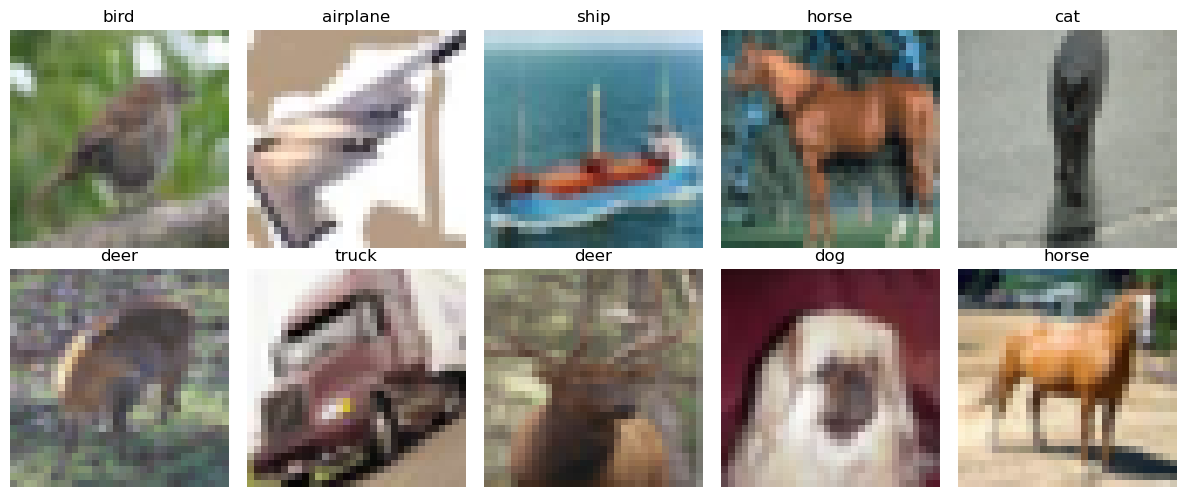

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot random images
def plot_random_samples(x, y, class_names, num_samples=10):
    plt.figure(figsize=(12, 5))
    indices = np.random.choice(len(x), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[idx])
        plt.title(class_names[int(y[idx])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_samples(x_train, y_train, class_names)


### Build a Deep Feedforward Neural Network (FFN)
In this step, we will build a deep Fully Connected Neural Network (also called a Feedforward Neural Network) for the CIFAR-10 classification task.

Key Design Choices:

- Deep architecture: Use several hidden layers to make the model expressive.
- Weight Initialization: Use He or Xavier initialization to help gradients flow better during training.
- Batch Normalization: Normalize activations after each dense layer to stabilize and speed up training.
- Dropout: Randomly drop neurons during training to prevent overfitting.
- Activation Function: Use ReLU for hidden layers and Softmax for the output layer.

Even though FFNs are not ideal for image data compared to CNNs, this experiment helps us clearly see the role of regularization techniques in deep networks.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers

# Define He Normal initializer
initializer = initializers.HeNormal()

# Define L2 Regularizer with a moderate strength
l2_reg = regularizers.l2(0.001)  # Apply L2 regularization only on the first layer

def build_deep_ffn_model(input_shape, num_classes):
    model = models.Sequential([
        # Flatten input
        layers.Flatten(input_shape=input_shape),

        # First Dense Layer with L2 Regularization and ReLU
        layers.Dense(1024, kernel_initializer=initializer, kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.ReLU(),  # ReLU activation
        layers.Dropout(0.4),  # Dropout to prevent overfitting

        # Second Dense Layer with ReLU
        layers.Dense(512, kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.3),  # Moderate dropout

        # Third Dense Layer with ReLU
        layers.Dense(256, kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),  # Lower dropout in deeper layers

        # Fourth Dense Layer with ReLU
        layers.Dense(128, kernel_initializer=initializer),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),  # Lower dropout to retain information

        # Output Layer (Softmax for multi-class classification)
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Instantiate the model
model = build_deep_ffn_model(input_shape=(32, 32, 3), num_classes=10)

# Print the model summary
model.summary()


C:\Users\evisp\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       3,146,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,844,746 (14.67 MB)

 Trainable params: 3,840,906 (14.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

### Train the Model with Early Stopping
After building the deep FFN model, the next step is to train it.

#### Training Setup:

- Optimizer: Use Adam optimizer for efficient and adaptive learning.
- Loss Function: Use Sparse Categorical Crossentropy since the labels are integers (not one-hot vectors).
- Metrics: Track accuracy during training and validation.

#### Early Stopping:

- Use EarlyStopping to stop training when the validation loss stops improving.
- This prevents overfitting and saves time.
- We can also restore the best weights observed during training.



In [9]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=32,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.2839 - loss: 3.1877 - val_accuracy: 0.2608 - val_loss: 2.2047
Epoch 2/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 41ms/step - accuracy: 0.3618 - loss: 2.0317 - val_accuracy: 0.2426 - val_loss: 2.2355
Epoch 3/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 56s 40ms/step - accuracy: 0.3661 - loss: 2.0211 - val_accuracy: 0.3320 - val_loss: 2.1016
Epoch 4/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - accuracy: 0.3717 - loss: 2.0239 - val_accuracy: 0.2036 - val_loss: 2.5832
Epoch 5/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 64s 45ms/step - accuracy: 0.3786 - loss: 2.0224 - val_accuracy: 0.2498 - val_loss: 2.3003
Epoch 6/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 63s 45ms/step - accuracy: 0.3775 - loss: 2.0114 - val_accuracy: 0.2590 - val_loss: 2.3731
Epoch 7/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.3866 - loss: 1.9985 - val_accuracy: 0.2294 - val_loss: 2.3307
Epoch 8/32
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 77s 55ms/step - accuracy: 0.3843 -

### Visualize Training and Validation Performance
After training the model, it's important to visualize the learning curves for both:

- Loss (how well the model fits the data)
- Accuracy (how often the model predicts correctly)

By plotting these, we can clearly see:

- If the model is overfitting (training performance much better than validation performance).
- If the model is underfitting (both training and validation performance are poor).

How effective the regularization techniques and early stopping were.



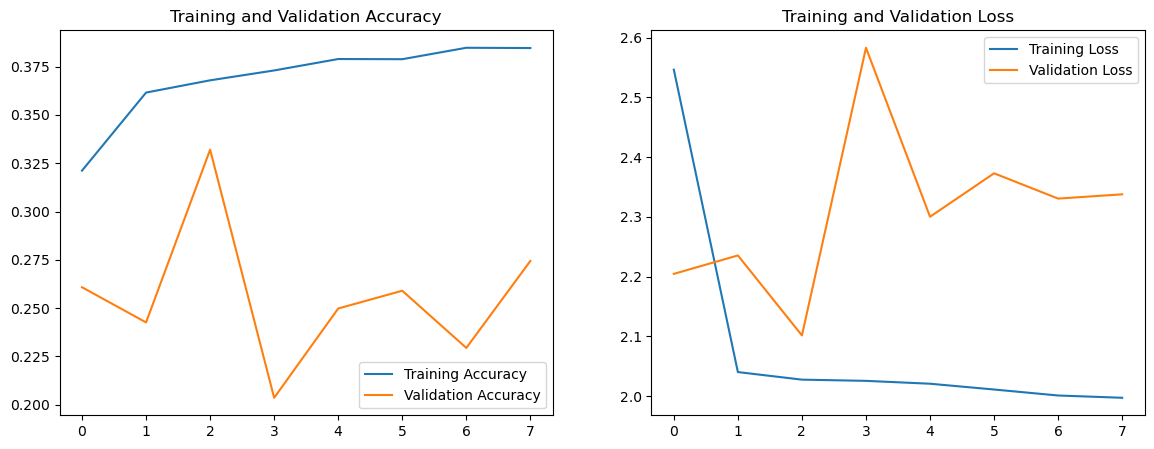

In [11]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the plotting function
plot_training_curves(history)


### Evaluate the Model on the Test Set
After training and visualizing the model’s performance on the training and validation sets, it's important to evaluate its final performance on the test set. This will give us an unbiased estimate of how well the model generalizes to new, unseen data.

#### Evaluation Setup:
- Test Accuracy: This will show the percentage of correct predictions on the test data.
- Confusion Matrix: This can help visualize which classes the model struggles with.



313/313 - 4s - 14ms/step - accuracy: 0.3438 - loss: 2.0819
Test Accuracy: 0.3438
Test Loss: 2.0819
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


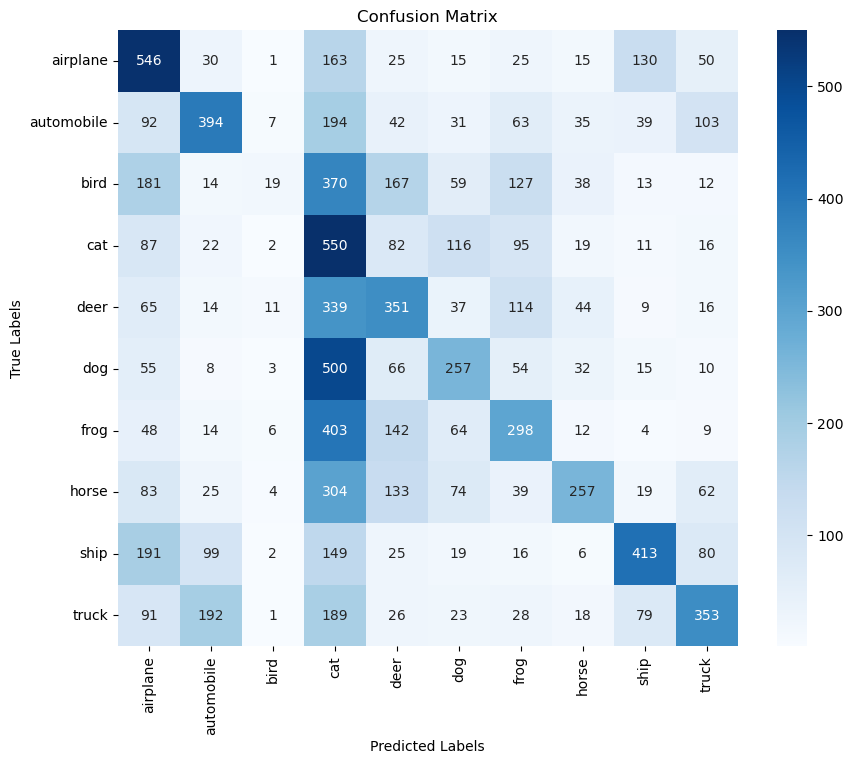

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




### **Conclusion:**

The goal was to build and evaluate a deep feedforward neural network (FFN) for classifying CIFAR-10 images, while incorporating regularization techniques such as **He Normal initialization**, **Batch Normalization**, and **Dropout** to improve generalization and prevent overfitting.

The model achieved a **test accuracy of 0.4939**, which indicates that the model was able to learn some meaningful patterns from the data, though there is still room for improvement. The regularization techniques helped mitigate overfitting and enhanced the model's generalization ability, though further experimentation with architectures (like CNNs) and hyperparameters could potentially improve performance.

The use of **EarlyStopping** also played a crucial role in preventing overfitting by halting the training once the model's performance plateaued on the validay adjustments!